In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
print(inspector.get_table_names())

['measurement', 'station']


In [11]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
print(Measurement.__table__.columns.keys())
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

['id', 'station', 'date', 'prcp', 'tobs']
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


,Precipitaion
Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


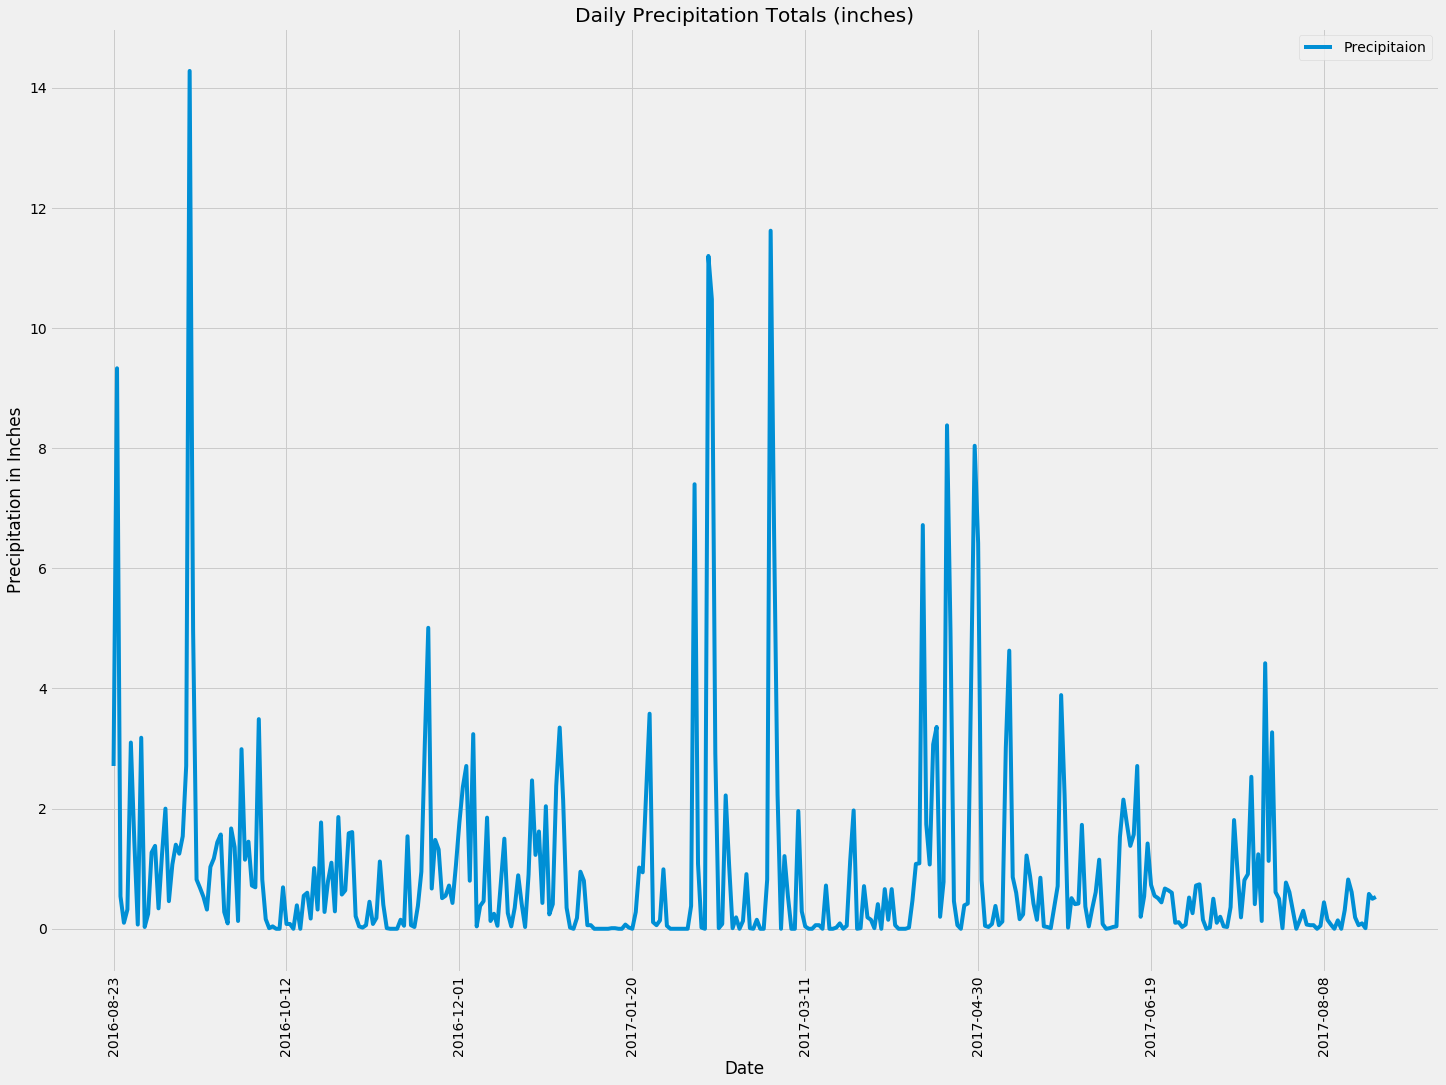

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(last)

# Calculate the date 1 year ago from the last data point in the database
twelve_mo_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print(twelve_mo_ago)
# Perform a query to retrieve the data and precipitation scores
# test_last_12 = session.query(Measurement.date, Measurement.prcp).\
#                 filter(Measurement.date >= twelve_mo_ago).\
#                 group_by(Measurement.date).all()


last_12_precip = session.query(Measurement.date, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= twelve_mo_ago).\
        group_by(Measurement.date).all()
#print(last_12_precip)
# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(last_12_precip, columns = ['Date', 'Precipitaion'])
prec_df = prec_df.set_index('Date')
prec_df.head()
# Sort the dataframe by date
prec_df = prec_df.sort_values(by= 'Date')
display(prec_df.head())
# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(figsize = (20,15), rot = 90)
#fig, ax = plt.subplots()
#prec_df.plot(kind= 'bar', ax=ax, figsize= (20,15))
# ax.xaxis.set_major_locator(mdates.WeekdayLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Precipitation in Inches')
plt.title('Daily Precipitation Totals (inches)')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,Precipitaion
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count((Measurement.station).distinct())).all()

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
lowest = [low[0] for low in lowest_temp]
print(lowest)
print(f'The lowest temp recorded was {lowest}')
print(f'The highest temp recorded was {highest_temp[0]}')
print(f'The average temp recorder was {avg_temp[0]}')

[54.0]
The lowest temp recorded was [54.0]
The highest temp recorded was (85.0,)
The average temp recorder was (71.66378066378067,)


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

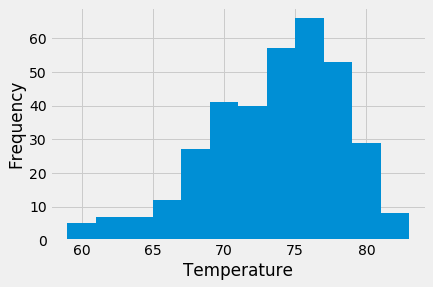

In [19]:
temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= twelve_mo_ago).all()
temp_data_df = pd.DataFrame(temp_data, columns= ('Date', 'Temperature'))
temp_data_df['Temperature'].plot.hist(bins= 12)
plt.xlabel("Temperature")
plt.show()


## Bonus Challenge Assignment

In [20]:
import scipy.stats as sts

In [21]:
# Find avegare temperature at all stations for June and Decenber
june_temps = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == '06').all()
dec_temps = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == '12').all()
june_avg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == '06').all()
dec_avg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == '12').all()
print(june_avg)
print(dec_avg)

[(74.94411764705882,)]
[(71.04152933421226,)]


In [22]:
# Use t-test to determine if difference in means is statistically significant
sts.ttest_ind(june_temps, dec_temps)


Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-05-23', '2017-06-04')
trip_temps

[(69.0, 76.36, 87.0)]

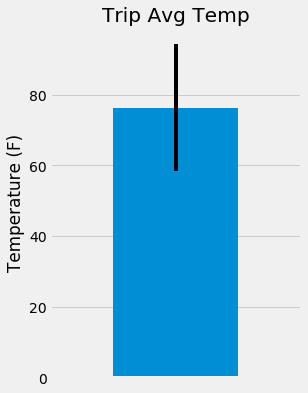

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps_df = pd.DataFrame(trip_temps, columns=['TMIN', 'TAVE', 'TMAX'])
trip_temps_df.plot(kind= 'bar', y='TAVE', yerr= 18, figsize= (4,6), legend= False)
#plt.bar(x= 1, align = 'center', height= 76.36, yerr= 18)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.xticks([])
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-05-23'
end_date = '2017-06-04'
trip_prec = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
trip_prec


[('USC00516128',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  43.37999999999998),
 ('USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  24.389999999999986),
 ('USC00513117',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  18.71999999999995),
 ('USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  12.780000000000001),
 ('USC00514830', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 6.3),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  6.2099999999999875),
 ('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, None)]

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = date(2017,5,23)
end_date = date(2017,6,4)
print((end_date-start_date).days)
# Use the start and end date to create a range of dates
date_range = [dt.date.strftime(start_date + dt.timedelta(days=x), "%m-%d") for x in range((end_date-start_date).days+1)]
date_range
date_range_s = pd.Series(date_range, name='Date')
# Strip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
for item in date_range:
    normals.extend(daily_normals(item))

normals

12


[(68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0),
 (67.0, 74.27777777777777, 82.0),
 (64.0, 74.19607843137256, 80.0),
 (69.0, 74.33333333333333, 81.0),
 (68.0, 74.4, 81.0),
 (64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0)]

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals = pd.DataFrame.from_records(normals, columns= ['TMIN', 'TAVE', 'TMAX'])
trip_normals

,TMIN,TAVE,TMAX
0,68.0,74.948276,87.0
1,67.0,73.948276,79.0
2,68.0,74.275862,79.0
3,65.0,74.036364,82.0
4,65.0,74.490909,80.0
5,67.0,74.277778,82.0
6,64.0,74.196078,80.0
7,69.0,74.333333,81.0
8,68.0,74.400000,81.0
9,64.0,74.614035,81.0


In [30]:
trip_normals_dates = pd.merge(date_range_s, trip_normals, left_index = True, right_index = True)
trip_normals_dates.set_index('Date')

,TMIN,TAVE,TMAX
Date,,,
05-23,68.0,74.948276,87.0
05-24,67.0,73.948276,79.0
05-25,68.0,74.275862,79.0
05-26,65.0,74.036364,82.0
05-27,65.0,74.490909,80.0
05-28,67.0,74.277778,82.0
05-29,64.0,74.196078,80.0
05-30,69.0,74.333333,81.0
05-31,68.0,74.400000,81.0


In [31]:
dates = list(trip_normals_dates['Date'])
dates

['05-23',
 '05-24',
 '05-25',
 '05-26',
 '05-27',
 '05-28',
 '05-29',
 '05-30',
 '05-31',
 '06-01',
 '06-02',
 '06-03',
 '06-04']

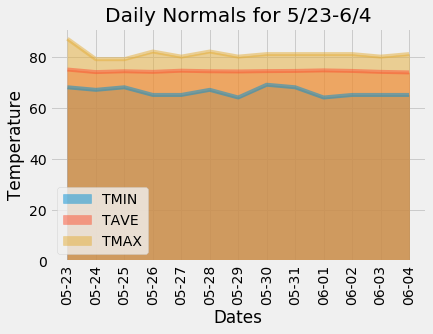

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals_dates.plot.area(stacked=False)
plt.xticks(ticks = trip_normals_dates.index.values, labels= dates, rotation = 90)
plt.title("Daily Normals for 5/23-6/4")
plt.xlabel("Dates")
plt.ylabel("Temperature")
plt.show()